In [1]:
# import  pandas, numpy, matplotlib, seaborn and os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [2]:
# create a directory to store the plots about performance of mapper and reducer
if not os.path.exists('performance_analysis_plots'):
     os.makedirs('performance_analysis_plots')

In [3]:
keys_list = [
    'CPU time spent (ms)', 
    'Total time spent by all map tasks (ms)',
    'Total time spent by all reduce tasks (ms)',
    'Peak Map Physical memory (bytes)',
	'Peak Map Virtual memory (bytes)',
	'Peak Reduce Physical memory (bytes)',
	'Peak Reduce Virtual memory (bytes)'
]

In [4]:
# For each file we have to read the data about 2 jobs
# 'Running job: job_1718873180387_0052' this line shows the start point of a job

# For each job we have to read the following lines to get the performance data and store them in a dataframe regarding mapper and reducer of the 2 jobs

# The first job is 'LetterCount' and the second job is 'LetterFrequency'

def get_performance_data_job(data):
    # job_number = 1 for 'LetterCount' and 2 for 'LetterFrequency'
    # key -> Running job
     
    counter = 0
    
    data_1_job = []
    data_2_job = []
    

    # get the index of the second job
    for i in range(len(data)):
        if 'Running job:' in data[i]:
            counter += 1
            if counter == 2:
                data_1_job = data[:i] # take the data until the second job start key
                data_2_job = data[i:] # take the data from the second job start key
                break

    # create a dictionary to store the performance data of the two jobs
    jobs = {
        'LetterCount': data_1_job,
        'LetterFrequency': data_2_job
    }
    
    return jobs

def get_performance_data(file):
    with open(file) as f:
        lines = f.readlines()
    
    # Separete the performance data of the two jobs
    jobs = get_performance_data_job(lines)  
        
    # each value of jobs is a list of strings that contains the performance data of a job (mapper and reducer)
    
    performance_data = {
        'LetterCount': {},
        'LetterFrequency': {}
    }
    
    # For each job
    for job_name, job in jobs.items():
        
        # get the start index of the performance data
            start_index = 0
            for j in range(len(job)):
                if 'Job Counters' in job[j]:
                    start_index = j
                    break
                
            # get the end index of the performance dataù
            end_index = 0
            for j in range(len(job)):
                if 'Shuffle Errors' in job[j]:
                    end_index = j
                    break
            
            # get the performance data
            data = job[start_index:end_index]
            
            # iterate over data to get values of keys_list
            
            # Example of data:
            
		    #Total time spent by all map tasks (ms)=25302
		    #Total time spent by all reduce tasks (ms)=2543
      
            #Peak Map Physical memory (bytes)=277716992
		    #Peak Map Virtual memory (bytes)=1868095488
		    #Peak Reduce Physical memory (bytes)=170889216
		    #Peak Reduce Virtual memory (bytes)=1872019456
            
      
            for line in data:
                for key in keys_list:
                    if key in line.strip():
                        value = int(line.split('=')[1])
                        performance_data[job_name][key] = value
                        
            
            # from the path of the file (i.e. .\resources\output\performance_analysis\dante\1_reducer\combiner\dante_normalized.txt) get the name of the opera or the author and the type (combiner or inmappercombiner)
            
            # get the file name from the full path
            file_name = os.path.basename(file)

            # extract the name of the opera or the author from the file name
            opera = file_name.split('.') # -> ['dante_normalized', 'txt']
            
            opera = opera[0] # -> 'dante_normalized'
            
            # the opera can have a name with more than one word (i.e. moby_dick)
            # if _normalized is present remove it
            opera = opera.split('_normalized')[0]

            # extract the type (combiner or inmappercombiner) from the path
            
            path_parts = file.split(os.sep)
            
            type_name = path_parts[-2]
            
            # numer of reducers
            # get the name of the folder from path_parts[-3]
            # get the number of reducers from the folder name
            # Example of folder name: 1_reducer
            
            folder_name = path_parts[-3]
            num_reducers = int(folder_name.split('_')[0])
            
            
            # store the data in the dictionary
            performance_data[job_name]['Opera'] = opera
            
            performance_data[job_name]['Type'] = type_name
            
            if job_name == 'LetterFrequency':

                performance_data[job_name]['NumReducers'] = num_reducers
            else:
                performance_data[job_name]['NumReducers'] = 1
                        
            
                            
    return performance_data
                                    

In [5]:
# define a funnction to create the proper file path name for the performance data

def get_dir_path(opera):
    # Get the current working directory
    current_dir = os.getcwd()
    
    # Navigate to the parent directory
    parent_dir = os.path.join(current_dir, os.pardir)
    
    # Join the different parts of the path in a platform-independent manner
    return os.path.join(parent_dir, 'resources', 'output', 'performance_analysis', opera)

In [6]:
# define a function to create a dataframe from the performance data
def create_performance_df(data):
    # Trasformare il dizionario in un DataFrame
    df = pd.DataFrame(data).T.reset_index()

    # Rinominare la colonna 'index' in 'Job'
    df.rename(columns={'index': 'Job'}, inplace=True)

    # Visualizzare il DataFrame
    return df

In [7]:
def process_file(file_path, dataframe):
    
    print(f"Processing file: {file_path}")
    data = get_performance_data(file_path)
    
    # if dataframe is empty, create it
    if dataframe.empty:
        df = create_performance_df(data)
    else:
        df = pd.concat([dataframe, create_performance_df(data)], ignore_index=True)
    
    return df
    
    
    

def iterate_and_process(root_folder):
    
    dataframe = pd.DataFrame()
    
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if '_normalized.txt' not in file:
                continue
            file_path = os.path.join(root, file)
            
            dataframe = process_file(file_path, dataframe)
            
    return dataframe
            

# Dante 
## Divina Commedia

In [8]:
# Percorso della cartella principale
root_folder = get_dir_path('dante')

# Chiamata alla funzione di iterazione
dante_df = iterate_and_process(root_folder)
dante_df

Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\dante\1_reducer\combiner\dante_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\dante\1_reducer\inmappercombiner\dante_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\dante\2_reducer\combiner\dante_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\dante\2_reducer\inmappercombiner\dante_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\dante\3_reducer\combiner\dante_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\noteboo

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,24292,2976,4180,271794176,1867763712,170389504,1872494592,dante,combiner,1
1,LetterFrequency,23703,2685,5180,277544960,1867853824,170303488,1872207872,dante,combiner,1
2,LetterCount,23931,3938,3420,279560192,1869385728,170164224,1872785408,dante,inmappercombiner,1
3,LetterFrequency,20769,2659,2970,275951616,1866358784,174817280,1876004864,dante,inmappercombiner,1
4,LetterCount,22202,3811,3860,276250624,1867288576,172171264,1871872000,dante,combiner,1
5,LetterFrequency,24458,5500,5810,277061632,1867739136,170442752,1872797696,dante,combiner,2
6,LetterCount,21140,2683,3190,274317312,1865289728,170856448,1872801792,dante,inmappercombiner,1
7,LetterFrequency,19921,5457,3460,276353024,1866829824,170881024,1872801792,dante,inmappercombiner,2
8,LetterCount,22612,2821,3790,277016576,1867350016,170475520,1872031744,dante,combiner,1
9,LetterFrequency,24008,9471,5800,273678336,1867898880,174800896,1876054016,dante,combiner,3


# Alessandro Manzoni
## Promessi Sposi

In [9]:
# Percorso della cartella principale
root_folder = get_dir_path('promessi_sposi')

# Chiamata alla funzione di iterazione
promessi_sposi_df = iterate_and_process(root_folder)
promessi_sposi_df

Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\promessi_sposi\1_reducer\combiner\promessi_sposi_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\promessi_sposi\1_reducer\inmappercombiner\promessi_sposi_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\promessi_sposi\2_reducer\combiner\promessi_sposi_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\promessi_sposi\2_reducer\inmappercombiner\promessi_sposi_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\promessi_sposi\3_reducer\combiner\promessi_sposi_normalized.txt

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,3499,2569,2440,275312640,1867071488,170356736,1871810560,promessi_sposi,combiner,1
1,LetterFrequency,3867,2750,3290,277041152,1866338304,170889216,1872052224,promessi_sposi,combiner,1
2,LetterCount,3120,3031,2240,274079744,1862639616,170569728,1872572416,promessi_sposi,inmappercombiner,1
3,LetterFrequency,3107,2599,1610,276156416,1864171520,172265472,1873416192,promessi_sposi,inmappercombiner,1
4,LetterCount,3681,2478,2490,277295104,1867124736,171819008,1872224256,promessi_sposi,combiner,1
5,LetterFrequency,3926,5555,4180,277700608,1866489856,170934272,1873227776,promessi_sposi,combiner,2
6,LetterCount,3505,2462,2360,274984960,1864400896,170151936,1872199680,promessi_sposi,inmappercombiner,1
7,LetterFrequency,2826,5652,2150,274608128,1861660672,171094016,1871507456,promessi_sposi,inmappercombiner,2
8,LetterCount,3497,3626,2420,275906560,1865883648,170590208,1871962112,promessi_sposi,combiner,1
9,LetterFrequency,4277,9531,5390,277905408,1865834496,172130304,1872814080,promessi_sposi,combiner,3


# Mary Shelley
## Frankenstein

In [10]:
# Percorso della cartella principale
root_folder = get_dir_path('frankenstein')


# Chiamata alla funzione di iterazione
frankenstein_df = iterate_and_process(root_folder)
frankenstein_df

Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\frankenstein\1_reducer\combiner\frankenstein_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\frankenstein\1_reducer\inmappercombiner\frankenstein_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\frankenstein\2_reducer\combiner\frankenstein_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\frankenstein\2_reducer\inmappercombiner\frankenstein_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\frankenstein\3_reducer\combiner\frankenstein_normalized.txt
Processing file: c:

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,3176,2918,2030,275873792,1866752000,170086400,1873133568,frankenstein,combiner,1
1,LetterFrequency,3431,2624,2240,274935808,1864749056,170397696,1871433728,frankenstein,combiner,1
2,LetterCount,4618,2776,1970,275828736,1863430144,170110976,1871998976,frankenstein,inmappercombiner,1
3,LetterFrequency,2790,2586,1430,275111936,1866760192,170520576,1871589376,frankenstein,inmappercombiner,1
4,LetterCount,3030,2711,1800,275349504,1866051584,170614784,1871249408,frankenstein,combiner,1
5,LetterFrequency,3457,5695,2810,275316736,1866203136,172556288,1873887232,frankenstein,combiner,2
6,LetterCount,2914,2978,1520,275824640,1864974336,169959424,1871802368,frankenstein,inmappercombiner,1
7,LetterFrequency,2824,5326,2100,274599936,1863131136,171241472,1873068032,frankenstein,inmappercombiner,2
8,LetterCount,3069,2820,1790,275509248,1865719808,170704896,1871556608,frankenstein,combiner,1
9,LetterFrequency,3303,8394,3740,276115456,1866043392,173133824,1872683008,frankenstein,combiner,3


# Herman Melville
## Moby Dick

In [11]:
# Percorso della cartella principale
root_folder = get_dir_path('moby_dick')

# Chiamata alla funzione di iterazione
moby_dick_df = iterate_and_process(root_folder)
moby_dick_df

Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\moby_dick\1_reducer\combiner\moby_dick_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\moby_dick\1_reducer\inmappercombiner\moby_dick_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\moby_dick\2_reducer\combiner\moby_dick_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\moby_dick\2_reducer\inmappercombiner\moby_dick_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\moby_dick\3_reducer\combiner\moby_dick_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Document

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,2852,2467,1990,274956288,1864654848,173776896,1874739200,moby_dick,combiner,1
1,LetterFrequency,3273,2674,2130,275746816,1867124736,170655744,1872502784,moby_dick,combiner,1
2,LetterCount,5137,2624,1620,276295680,1865363456,172670976,1873743872,moby_dick,inmappercombiner,1
3,LetterFrequency,2883,2721,1400,274665472,1864544256,170254336,1872990208,moby_dick,inmappercombiner,1
4,LetterCount,3205,2783,1920,275427328,1866313728,169828352,1872015360,moby_dick,combiner,1
5,LetterFrequency,3280,5444,2800,275623936,1866153984,170782720,1871921152,moby_dick,combiner,2
6,LetterCount,2969,2812,1820,275591168,1865244672,170569728,1871650816,moby_dick,inmappercombiner,1
7,LetterFrequency,2813,5412,2010,274894848,1864622080,171167744,1872396288,moby_dick,inmappercombiner,2
8,LetterCount,3158,2536,1950,275427328,1866313728,170045440,1871740928,moby_dick,combiner,1
9,LetterFrequency,3072,9392,3400,277303296,1867452416,171401216,1874145280,moby_dick,combiner,3


# John Milton
## Paradise Lost

In [12]:
# Percorso della cartella principale
root_folder = get_dir_path('paradise_lost')

# Chiamata alla funzione di iterazione
paradise_lost_df = iterate_and_process(root_folder)
paradise_lost_df

Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\paradise_lost\1_reducer\combiner\paradise_lost_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\paradise_lost\1_reducer\inmappercombiner\paradise_lost_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\paradise_lost\2_reducer\combiner\paradise_lost_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\paradise_lost\2_reducer\inmappercombiner\paradise_lost_normalized.txt
Processing file: c:\Users\gemel\OneDrive\Documenti\GitHub\hadoop-letter-frequency\notebooks\..\resources\output\performance_analysis\paradise_lost\3_reducer\combiner\paradise_lost_normalized.txt
Processin

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,2937,2952,1630,274939904,1863155712,171327488,1872089088,paradise_lost,combiner,1
1,LetterFrequency,3439,3730,2250,276267008,1864499200,170647552,1872048128,paradise_lost,combiner,1
2,LetterCount,2954,2637,1450,274497536,1864216576,171028480,1872515072,paradise_lost,inmappercombiner,1
3,LetterFrequency,3059,2430,1270,274030592,1863643136,170094592,1871912960,paradise_lost,inmappercombiner,1
4,LetterCount,2889,2868,1620,275091456,1864400896,170344448,1872453632,paradise_lost,combiner,1
5,LetterFrequency,3130,6688,2750,276459520,1864581120,170315776,1872510976,paradise_lost,combiner,2
6,LetterCount,3078,2778,1620,274415616,1862787072,170352640,1871929344,paradise_lost,inmappercombiner,1
7,LetterFrequency,3064,6503,1970,274558976,1863475200,171085824,1872015360,paradise_lost,inmappercombiner,2
8,LetterCount,3167,2628,1670,275177472,1866657792,170242048,1871392768,paradise_lost,combiner,1
9,LetterFrequency,3094,8326,3230,275836928,1864953856,170795008,1873035264,paradise_lost,combiner,3


In [13]:
# concat al the dfs
df_list = [dante_df, promessi_sposi_df, frankenstein_df, moby_dick_df, paradise_lost_df]

df_concat = pd.concat(df_list, ignore_index=True)

df_concat

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,24292,2976,4180,271794176,1867763712,170389504,1872494592,dante,combiner,1
1,LetterFrequency,23703,2685,5180,277544960,1867853824,170303488,1872207872,dante,combiner,1
2,LetterCount,23931,3938,3420,279560192,1869385728,170164224,1872785408,dante,inmappercombiner,1
3,LetterFrequency,20769,2659,2970,275951616,1866358784,174817280,1876004864,dante,inmappercombiner,1
4,LetterCount,22202,3811,3860,276250624,1867288576,172171264,1871872000,dante,combiner,1
5,LetterFrequency,24458,5500,5810,277061632,1867739136,170442752,1872797696,dante,combiner,2
6,LetterCount,21140,2683,3190,274317312,1865289728,170856448,1872801792,dante,inmappercombiner,1
7,LetterFrequency,19921,5457,3460,276353024,1866829824,170881024,1872801792,dante,inmappercombiner,2
8,LetterCount,22612,2821,3790,277016576,1867350016,170475520,1872031744,dante,combiner,1
9,LetterFrequency,24008,9471,5800,273678336,1867898880,174800896,1876054016,dante,combiner,3


### LetterCount job

In [14]:
df_count_job = df_concat[df_concat.Job == 'LetterCount']
df_count_job

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
0,LetterCount,24292,2976,4180,271794176,1867763712,170389504,1872494592,dante,combiner,1
2,LetterCount,23931,3938,3420,279560192,1869385728,170164224,1872785408,dante,inmappercombiner,1
4,LetterCount,22202,3811,3860,276250624,1867288576,172171264,1871872000,dante,combiner,1
6,LetterCount,21140,2683,3190,274317312,1865289728,170856448,1872801792,dante,inmappercombiner,1
8,LetterCount,22612,2821,3790,277016576,1867350016,170475520,1872031744,dante,combiner,1
10,LetterCount,33628,2640,3450,275542016,1869873152,170672128,1873387520,dante,inmappercombiner,1
12,LetterCount,3499,2569,2440,275312640,1867071488,170356736,1871810560,promessi_sposi,combiner,1
14,LetterCount,3120,3031,2240,274079744,1862639616,170569728,1872572416,promessi_sposi,inmappercombiner,1
16,LetterCount,3681,2478,2490,277295104,1867124736,171819008,1872224256,promessi_sposi,combiner,1
18,LetterCount,3505,2462,2360,274984960,1864400896,170151936,1872199680,promessi_sposi,inmappercombiner,1


### LetterFrequency job

In [15]:
df_frequency_job = df_concat[df_concat.Job == 'LetterFrequency']
df_frequency_job

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers
1,LetterFrequency,23703,2685,5180,277544960,1867853824,170303488,1872207872,dante,combiner,1
3,LetterFrequency,20769,2659,2970,275951616,1866358784,174817280,1876004864,dante,inmappercombiner,1
5,LetterFrequency,24458,5500,5810,277061632,1867739136,170442752,1872797696,dante,combiner,2
7,LetterFrequency,19921,5457,3460,276353024,1866829824,170881024,1872801792,dante,inmappercombiner,2
9,LetterFrequency,24008,9471,5800,273678336,1867898880,174800896,1876054016,dante,combiner,3
11,LetterFrequency,21056,8191,4030,275095552,1866592256,171524096,1872433152,dante,inmappercombiner,3
13,LetterFrequency,3867,2750,3290,277041152,1866338304,170889216,1872052224,promessi_sposi,combiner,1
15,LetterFrequency,3107,2599,1610,276156416,1864171520,172265472,1873416192,promessi_sposi,inmappercombiner,1
17,LetterFrequency,3926,5555,4180,277700608,1866489856,170934272,1873227776,promessi_sposi,combiner,2
19,LetterFrequency,2826,5652,2150,274608128,1861660672,171094016,1871507456,promessi_sposi,inmappercombiner,2


In [52]:
df_frequency_job.loc[df_frequency_job['Opera']=='dante', 'Opera'] = 'divina_commedia'

In [53]:
lang_dict ={
    'divina_commedia': 'it',
    'promessi_sposi': 'it',
    'gerusalemme_liberata': 'it',
    'moby_dick': 'en',
    'paradise_lost': 'en',
    'frankenstein': 'en'
}

df_frequency_job['Lang'] = df_frequency_job['Opera'].apply(lambda x: lang_dict[x] if x in lang_dict else None) 

C:\Users\gemel\AppData\Local\Temp\ipykernel_2444\1982882803.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frequency_job['Lang'] = df_frequency_job['Opera'].apply(lambda x: lang_dict[x] if x in lang_dict else None)


In [ ]:
numeric_columns = [
    'Total time spent by all map tasks (ms)',
    'Total time spent by all reduce tasks (ms)',
    'CPU time spent (ms)',
    'Peak Map Physical memory (bytes)',
    'Peak Map Virtual memory (bytes)',
    'Peak Reduce Physical memory (bytes)',
    'Peak Reduce Virtual memory (bytes)',
    'NumReducers'
]

# Iterazione attraverso le colonne e conversione in numeriche
for col in numeric_columns:
    df_frequency_job[col] = pd.to_numeric(df_frequency_job[col], errors='coerce')

In [18]:
df_frequency_job.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 1 to 59
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Job                                        30 non-null     object
 1   Total time spent by all map tasks (ms)     30 non-null     int64 
 2   Total time spent by all reduce tasks (ms)  30 non-null     int64 
 3   CPU time spent (ms)                        30 non-null     int64 
 4   Peak Map Physical memory (bytes)           30 non-null     int64 
 5   Peak Map Virtual memory (bytes)            30 non-null     int64 
 6   Peak Reduce Physical memory (bytes)        30 non-null     int64 
 7   Peak Reduce Virtual memory (bytes)         30 non-null     int64 
 8   Opera                                      30 non-null     object
 9   Type                                       30 non-null     object
 10  NumReducers                                30

In [19]:
df_frequency_job['Total_Time(ms)'] = df_frequency_job['Total time spent by all map tasks (ms)'] + df_frequency_job['Total time spent by all reduce tasks (ms)']

C:\Users\gemel\AppData\Local\Temp\ipykernel_2444\1497000313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frequency_job['Total_Time(ms)'] = df_frequency_job['Total time spent by all map tasks (ms)'] + df_frequency_job['Total time spent by all reduce tasks (ms)']


In [20]:
df_frequency_job

,Job,Total time spent by all map tasks (ms),Total time spent by all reduce tasks (ms),CPU time spent (ms),Peak Map Physical memory (bytes),Peak Map Virtual memory (bytes),Peak Reduce Physical memory (bytes),Peak Reduce Virtual memory (bytes),Opera,Type,NumReducers,Total_Time(ms)
1,LetterFrequency,23703,2685,5180,277544960,1867853824,170303488,1872207872,dante,combiner,1,26388
3,LetterFrequency,20769,2659,2970,275951616,1866358784,174817280,1876004864,dante,inmappercombiner,1,23428
5,LetterFrequency,24458,5500,5810,277061632,1867739136,170442752,1872797696,dante,combiner,2,29958
7,LetterFrequency,19921,5457,3460,276353024,1866829824,170881024,1872801792,dante,inmappercombiner,2,25378
9,LetterFrequency,24008,9471,5800,273678336,1867898880,174800896,1876054016,dante,combiner,3,33479
11,LetterFrequency,21056,8191,4030,275095552,1866592256,171524096,1872433152,dante,inmappercombiner,3,29247
13,LetterFrequency,3867,2750,3290,277041152,1866338304,170889216,1872052224,promessi_sposi,combiner,1,6617
15,LetterFrequency,3107,2599,1610,276156416,1864171520,172265472,1873416192,promessi_sposi,inmappercombiner,1,5706
17,LetterFrequency,3926,5555,4180,277700608,1866489856,170934272,1873227776,promessi_sposi,combiner,2,9481
19,LetterFrequency,2826,5652,2150,274608128,1861660672,171094016,1871507456,promessi_sposi,inmappercombiner,2,8478


In [21]:
df_frequency_job.describe().T

,count,mean,std,min,25%,50%,75%,max
Total time spent by all map tasks (ms),30.0,7.008600e+03,7.836301e+03,2.692000e+03,2.968000e+03,3.201500e+03,3.911250e+03,2.445800e+04
Total time spent by all reduce tasks (ms),30.0,5.772833e+03,2.580935e+03,2.430000e+03,2.728250e+03,5.527500e+03,8.231500e+03,9.531000e+03
CPU time spent (ms),30.0,3.000333e+03,1.257061e+03,1.270000e+03,2.135000e+03,2.775000e+03,3.445000e+03,5.810000e+03
Peak Map Physical memory (bytes),30.0,2.756799e+08,1.132837e+06,2.736783e+08,2.747597e+08,2.756055e+08,2.763315e+08,2.779054e+08
Peak Map Virtual memory (bytes),30.0,1.865350e+09,1.648688e+06,1.861661e+09,1.864253e+09,1.865394e+09,1.866567e+09,1.867899e+09
Peak Reduce Physical memory (bytes),30.0,1.713850e+08,1.204340e+06,1.700946e+08,1.706496e+08,1.710305e+08,1.715548e+08,1.748173e+08
Peak Reduce Virtual memory (bytes),30.0,1.872819e+09,1.113251e+06,1.871434e+09,1.872049e+09,1.872597e+09,1.873083e+09,1.876054e+09
NumReducers,30.0,2.000000e+00,8.304548e-01,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
Total_Time(ms),30.0,1.278143e+04,8.208314e+03,5.376000e+03,7.414250e+03,9.692500e+03,1.243125e+04,3.347900e+04


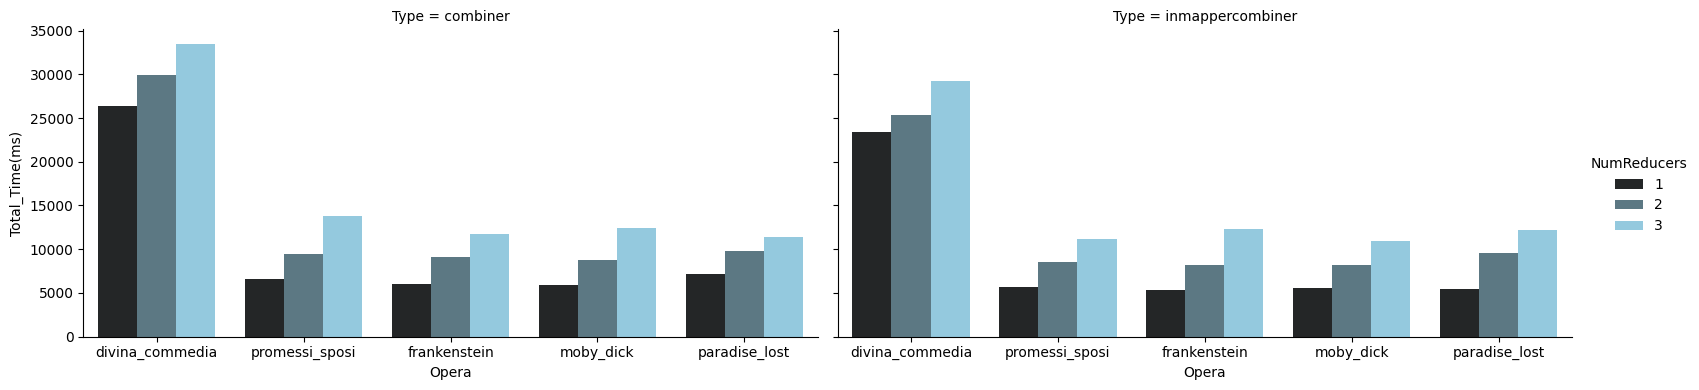

In [68]:

sns.catplot(
    data=df_frequency_job, kind="bar",
    x="Opera", y='Total_Time(ms)', col="Type", hue="NumReducers",
    height=4, aspect=2, palette='dark:skyblue'
)



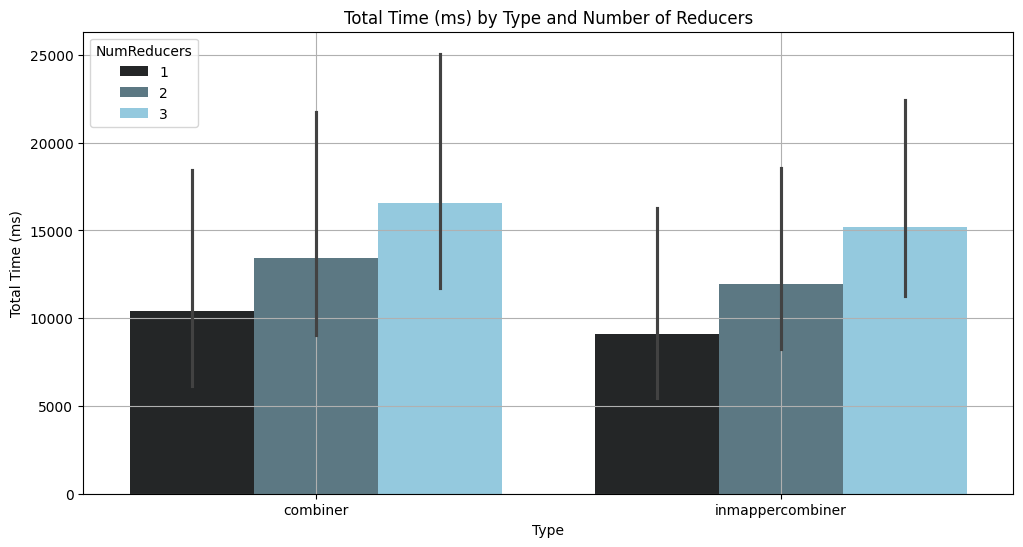

In [64]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Type', y='Total_Time(ms)', hue='NumReducers', data=df_frequency_job, palette='dark:skyblue')

plt.xlabel('Type')
plt.ylabel('Total Time (ms)')
plt.title('Total Time (ms) by Type and Number of Reducers')
plt.legend(title='NumReducers')
plt.grid(True)
plt.show()

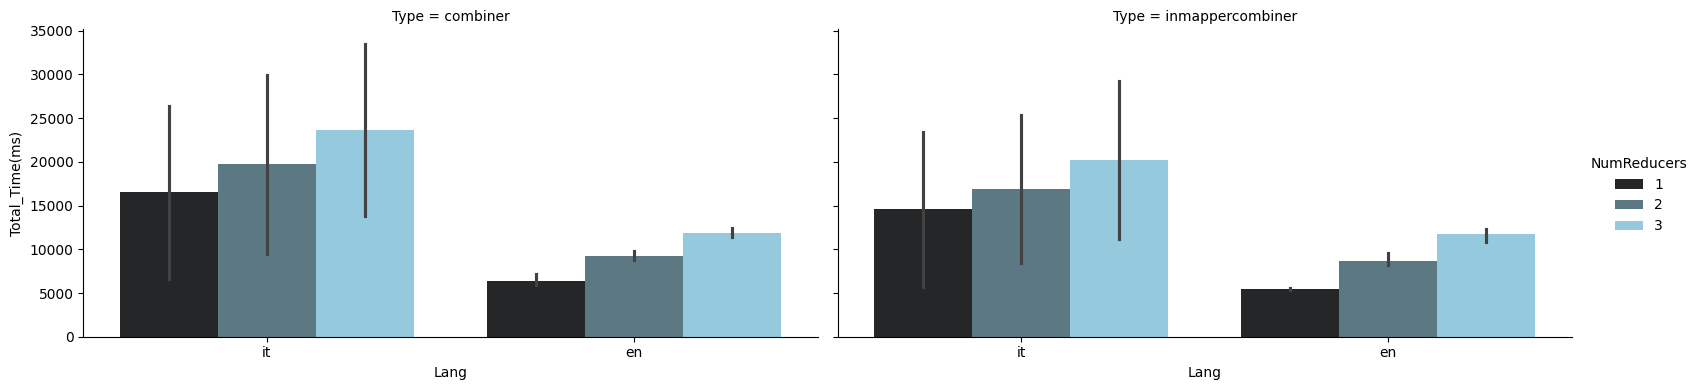

In [62]:
sns.catplot(
    data=df_frequency_job, kind="bar",
    x="Lang", y='Total_Time(ms)', col="Type", hue="NumReducers",
    height=4, aspect=2, palette='dark:skyblue'
)

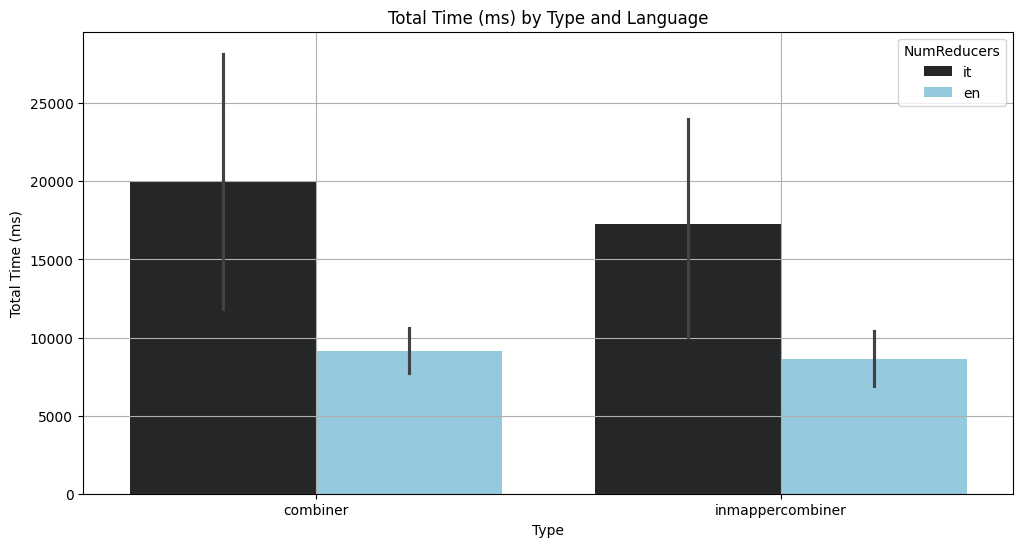

In [65]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Type', y='Total_Time(ms)', hue='Lang', data=df_frequency_job, palette='dark:skyblue')

plt.xlabel('Type')
plt.ylabel('Total Time (ms)')
plt.title('Total Time (ms) by Type and Language')
plt.legend(title='NumReducers')
plt.grid(True)
plt.show()

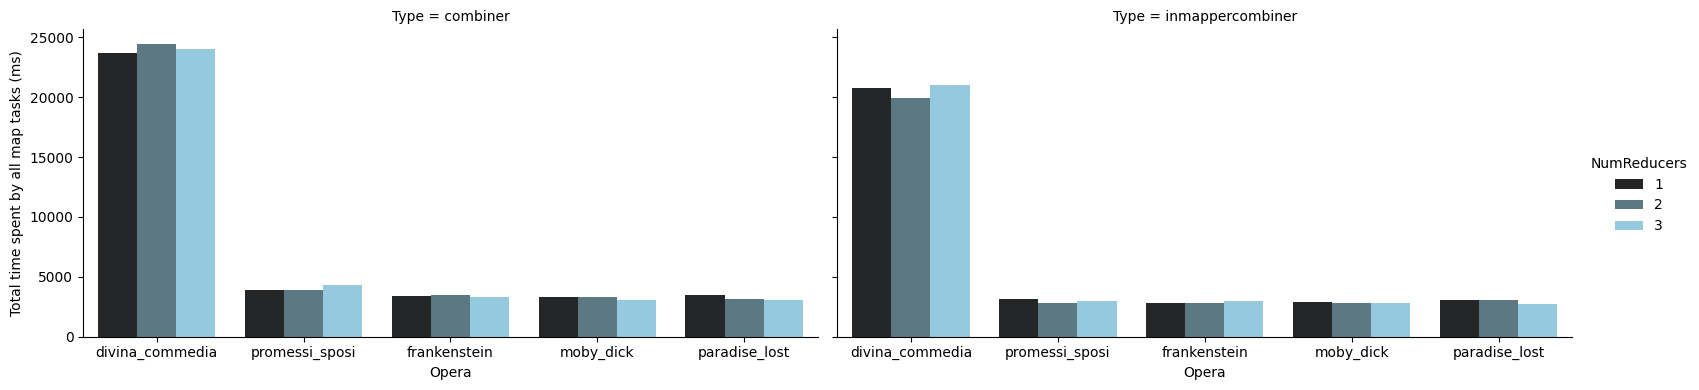

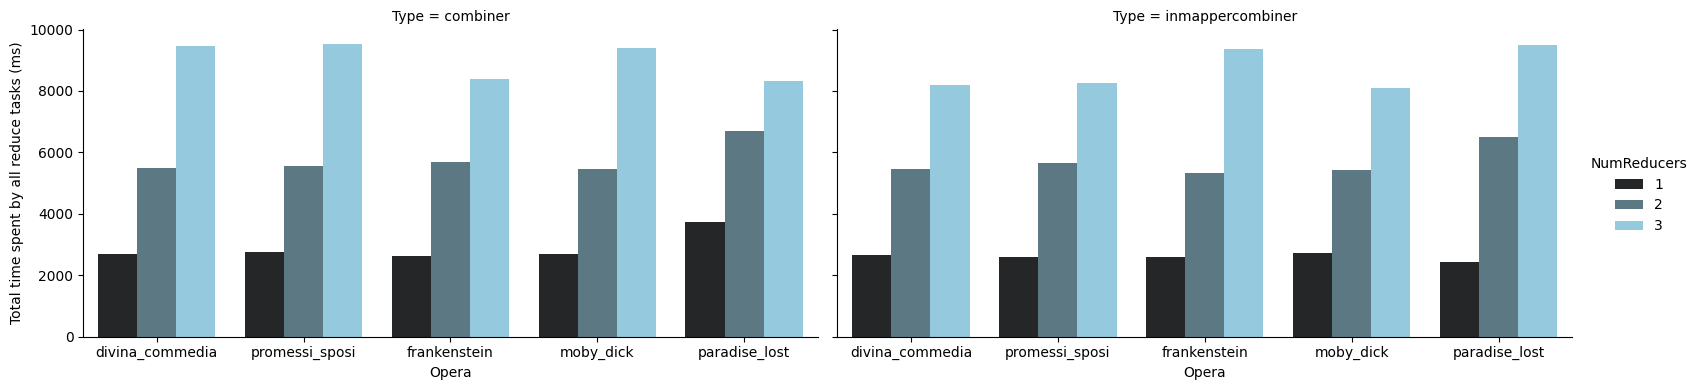

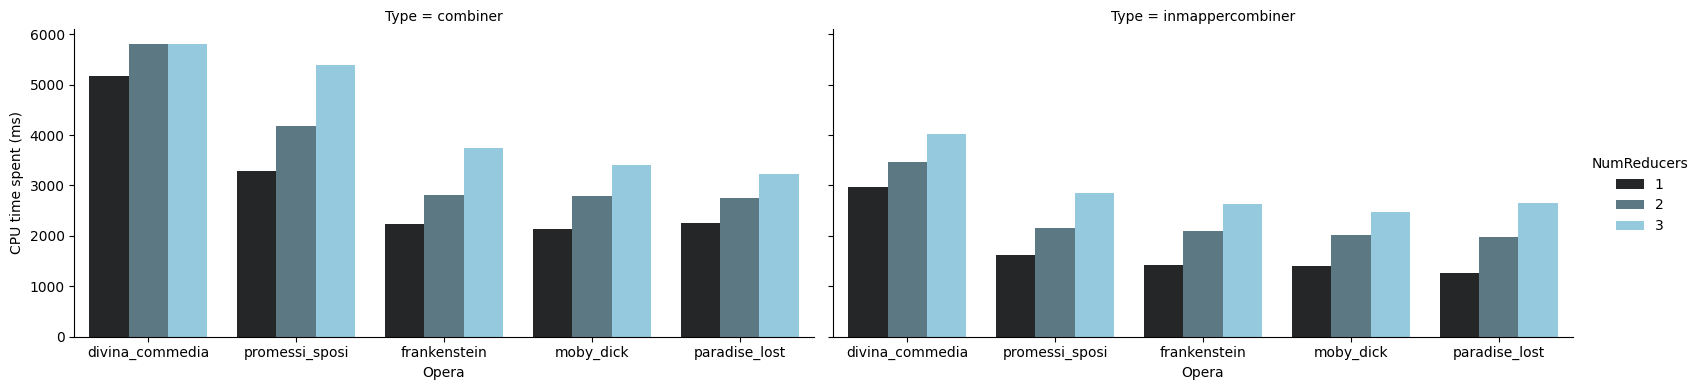

In [70]:
l = ['Total time spent by all map tasks (ms)',	'Total time spent by all reduce tasks (ms)',	'CPU time spent (ms)']
for col in l:
    sns.catplot(
    data=df_frequency_job, kind="bar",
    x="Opera", y=col, col="Type", hue="NumReducers",
    height=4, aspect=2, palette='dark:skyblue'
)   